# YOLO(You Only Look Once)

Detecting vehicles in a video stream is an object detection problem. An object detection problem can be approached as either a classification problem or a regression problem. As a classification problem, the image are divided into small patches, each of which will be run through a classifier to determine whether there are objects in the patch. Then the bounding boxes will be assigned to locate around patches that are classified with high probability of present of an object. In the regression approach, the whole image will be run through a convolutional neural network to directly generate one or more bounding boxes for objects in the images. In YOLO, regression approach is used. 

Traditional, computer vision technique based, approaches for object detection systems repurpose classifiers to perform detection. To detect an object, these systems take a classifier for that object and evaluate it at various locations and scales in a test image. Systems like deformable parts models (DPM) use a sliding window approach where the classifier is run at evenly spaced locations over the entire image.

Other approaaches like R-CNN use region proposal methods to first generate potential bounding boxes in an image and then run a classifier on these proposed boxes. After classification, post-processing is used to refine the bounding boxes, eliminate duplicate detections, and rescore the boxes based on other objects in the scene. These complex pipelines are slow and hard to optimize because each individual component must be trained separately.

YOLO reframes object detection as a single regression problem, straight from image pixels to bounding box coordinates and class probabilities. A single convolutional network simultaneously predicts multiple bounding boxes and class probabilities for those boxes. YOLO trains on full images and directly optimizes detection performance.

For detecting just the cars, here we are using tiny-YOLO v1. Full implementation of YOLO can be found in the research paper https://arxiv.org/abs/1506.02640 by Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi.
Also check out https://github.com/pjreddie/darknet/wiki/YOLO:-Real-Time-Object-Detection and 
https://pjreddie.com/darknet/yolo/ 

## Design and Implementation 

The system divides the input image into an SxS grid. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. Each grid cell predicts B bounding boxes and confidence scores for those boxes.

Each grid cell predicts B bounding boxes and confidence scores for those boxes. These confidence scores reflect how confident the model is that the box contains an object and also how accurate it thinks the box is that it predicts.
Confidence is defined as (Probability that the grid cell contains an object) multiplied by (Intersection over union of predicted bounding box over the ground truth) described as :

Confidence = Pr(Object) x IOU_truth_pred

If no object exists in that cell, the confidence scores should be zero. Otherwise we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth. 

Each bounding box consists of 5 predictions:
- x , y : coordinates representing the center of the box relative to the bounds of the grid cell.
- w, h  : width and height which are predicted relative to the whole image.
- confidence : confidence prediction representing the IOU between the predicted box and any ground truth box.

Each grid cell also predicts C conditional class probabilities, Pr(Classi|Object). These probabilities are conditioned on the grid cell containing an object. We only predict one set of class probabilities per grid cell, regardless of the number of boxes B.

At test time we multiply the conditional class probabilities and the individual box confidence predictions as :

Pr(Class|Object) x Pr(Object) x IOU_truth_pred = Pr(Class) x IOU_truth_pred 

which gives us class-specific confidence scores for each box. These scores encode both the probability of that class appearing in the box and how well the predicted box fits the object.



In [35]:
#all imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

## Training

We have used pre trained weights for implementing YOLO which can be downloaded from https://github.com/pjreddie/darknet/wiki/YOLO:-Real-Time-Object-Detection. You can download whole, smaller and tiny weights depending on your needs.

Training is done in 2 parts
Part 1: Training for classification

This model was trained on ImageNet 1000-class classification dataset. For this we take the first 6 convolutional layers followed by a followed by a fully connected layer.

Part 2: Training for detection

The model is then converted for detection. This is done by adding 3 convolutional layers and 3 fully connected layers. The modified model is then trained on PASCAL VOC detection dataset.

In [36]:
"""The model architecture consists of 9 convolutional layers, 
followed by 3 fully connected layers. Each convolutional layer is followed by a Leaky RELU activation function,
with alpha of 0.1. The first 6 convolutional layers also have a 2x2 max pooling layers.
Please refer the model architecture diagram in the research paper link provided above"""

# Pre trained weights require this ordering
keras.backend.set_image_dim_ordering('th')

def model_keras():
    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 3
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 4
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 5
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 6
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 7
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 8
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 9
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    # Layer 10
    model.add(Dense(256))
    
    # Layer 11
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 12
    model.add(Dense(1470))
    
    return model

## Preprocessing the image

In [37]:
# Preprocessing
def preprocess(image):
    cropped = image[300:650,500:,:] #cropping for selecting our area of interest as we don't detect cars in sky
    resized = cv2.resize(cropped, (448,448)) #resizing to 448x448 image
    normalized = 2.0*resized/255.0 - 1       #normalizing between -1 and 1
    
    # The model works on (channel, height, width) ordering of dimensions
    transposed = np.transpose(normalized, (2,0,1))
    return transposed

The model was trained on PASCAL VOC dataset. We use S = 7, B = 2. PASCAL VOC has 20 labelled classes so C = 20. So our final prediction, for each input image, is:

output tensor length = S x S x (B x 5 + C)
output tensor length = 7 x 7 x (2x5 + 20)
output tensor length = 1470.

In YOLO, car is at class number 6.

In [38]:

# Load weights
from weights_boxes import load_weights

model = model_keras()
load_weights(model,'yolo-tiny.weights')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_19 (Convolution2D) (None, 16, 448, 448)  448         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
leakyrelu_21 (LeakyReLU)         (None, 16, 448, 448)  0           convolution2d_19[0][0]           
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 16, 224, 224)  0           leakyrelu_21[0][0]               
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 32, 224, 224)  4640        maxpooling2d_13[0][0]            
___________________________________________________________________________________________

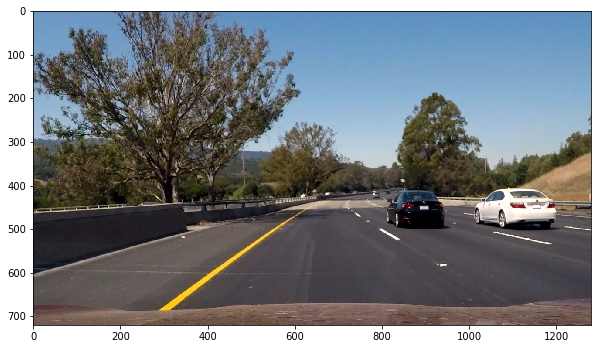

In [58]:
#image for testing
test_img = mpimg.imread('test_images/test6.jpg')
cop = np.copy(test_img)
plt.imshow(test_img)

In [59]:
preprocessed = preprocess(test_img)
batch = np.expand_dims(preprocessed,axis = 0)
print("input batch shape:" + str(batch.shape))
out_batch = model.predict(batch)
print("shape of predicted batch :" + str(out_batch.shape))


input batch shape:(1, 3, 448, 448)
shape of predicted batch :(1, 1470)


### Output predicted :
The model was trained on PASCAL VOC dataset. We use S = 7, B = 2. PASCAL VOC has 20 labelled classes so C = 20. So our final prediction, for each input image, is:

output tensor length = S x S x (B x 5 + C)= 7 x 7 x (2x5 + 20)= 1470.


## Deriving boxes from predictions

car_boxes_from_yolo_output() function rejects the boxes with class scores below a certain threshold(we have taken 0.17 in this case). Here we are considering just for single object class i.e car whose class number is 6 in YOLO.

If we get multiple bounding boxes for each class then we calculate IOU . If we get IOU of more than 40% we only keep the box with highest score. 

In [41]:
# code based on:
# YAD2K https://github.com/allanzelener/YAD2K
# darkflow https://github.com/thtrieu/darkflow
# Darknet.keras https://github.com/sunshineatnoon/Darknet.keras
# https://github.com/xslittlegrass/CarND-Vehicle-Detection
# https://github.com/subodh-malgonde/vehicle-detection/


class Box:

    def _init_(self):
        self.x = float()
        self.y = float()
        self.w = float()
        self.h = float()
        self.c = float()
        self.prob = float()


#finding overlapping with respect to width and height
def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


#finding the area of overlapping/intersection with the help of above function
def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    else:
        area = w * h
        return area

#finding union 
def box_union(a, b):
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i  #using A U B = A + B - intersect(A,B) 
    return u

#intersection over union is the ratio of area of intersection to the union area of two bounding boxes
def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b)


def car_boxes_from_yolo_output(out, threshold = 0.2, sqrt=1.8,C=20, B=2, S=7):
    class_num = 6  #for car class num is 6
    boxes = []
    SS        =  S * S # number of grid cells
    prob_size = SS * C # class probabilities
    conf_size = SS * B # confidences for each grid cell




    """
    output tensor is of length 1470 which is described as follows:


    1.First 980 values are the probabilities for each of the 20 classes for each grid cell. 
    These probabilities are conditioned on objects being present in each grid cell. 


    2.The next 98 values are confidence scores for 2 bounding boxes predicted by each grid cells.

    3.The next 392 values gives co-ordinates (x, y, w, h) for 2 bounding boxes per grid cell.

    The next 3 lines represent this.


    """
    probs = out[0 : prob_size]
    confs = out[prob_size : (prob_size + conf_size)]
    cords = out[(prob_size + conf_size) : ]

    #reshaping
    probs = probs.reshape([SS, C])
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])

    for grid in range(SS):    #looping over each grid from 0 to 48
        for b in range(B):    #looping over each 2 boxes per grid
            bx   = Box()
            bx.c =  confs[grid, b]

            """ We normalize the bounding box width & height so that they will be in 0 to 1. We paramterize the bounding box x and y
            to be offsets of a particular grid location so they are also bounded by 0 to 1 """


            bx.x = (cords[grid, b, 0] + grid %  S) / S 
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w =  cords[grid, b, 2] ** sqrt 
            bx.h =  cords[grid, b, 3] ** sqrt
            p = probs[grid, :] * bx.c    #class specific confidence scores(Pr(Class|Object) x Pr(Object))

            if p[class_num] >= threshold: #checking if the probability of car class is greater than threshold
                bx.prob = p[class_num]
                boxes.append(bx)


    # combine boxes that are overlap

    #arranging the boxes in the descending order of confidence scores
    boxes.sort(key=lambda b:b.prob,reverse=True)



    for i in range(len(boxes)):
        box = boxes[i]
        if box.prob == 0 or box.prob == 0.0:   #if the box doesn't detect any object skip it
            continue


        for j in range(i + 1, len(boxes)):  #looping over next box 1 ahead of previous
            box_nxt = boxes[j]

            if box_iou(box, box_nxt) >= 0.4:  #If boxes have more than 40% overlap then retain the box with the highest confidence score
                boxes[j].prob = 0.0 

    boxes = [b for b in boxes if b.prob > 0.0 or b.prob > 0] #removing all boxes with zero confidence"""


    return boxes

### Drawing the boxes 

The predictions (x, y) for each bounding box are relative to the bounds of the grid cell and (w, h) are relative to the whole image. To compute the final bounding box coodinates we have to multiply w & h with the width & height of the portion of the image used as input for the network.

In [67]:
def draw_boxes(boxes,im,crop_dim):
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(imgcv, (left, top), (right, bot), (0,255,0), thick)
        
    return imgcv

In [60]:
boxes = car_boxes_from_yolo_output(out_batch[0], threshold=0.17)
final_out = draw_boxes(boxes,test_img,((500,1280),(300,650)))

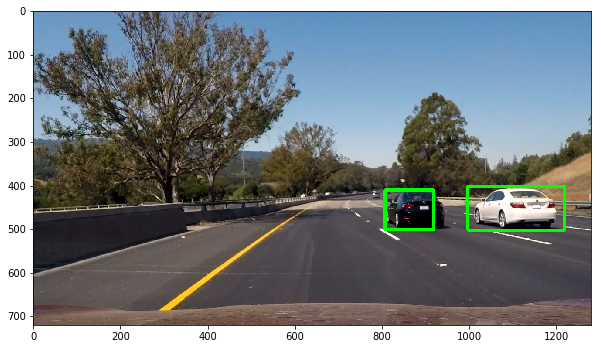

In [61]:
plt.imshow(final_out)

In [62]:
def final_pipeline(image):
    preprocessed_ = preprocess(image)
    batch_ = np.expand_dims(preprocessed_,axis = 0)
    out_batch_ = model.predict(batch_)
    boxes_ = car_boxes_from_yolo_output(out_batch_[0], threshold=0.17)
    final_out_ = draw_boxes(boxes_,image,((500,1280),(300,650)))
    
    return final_out_

6


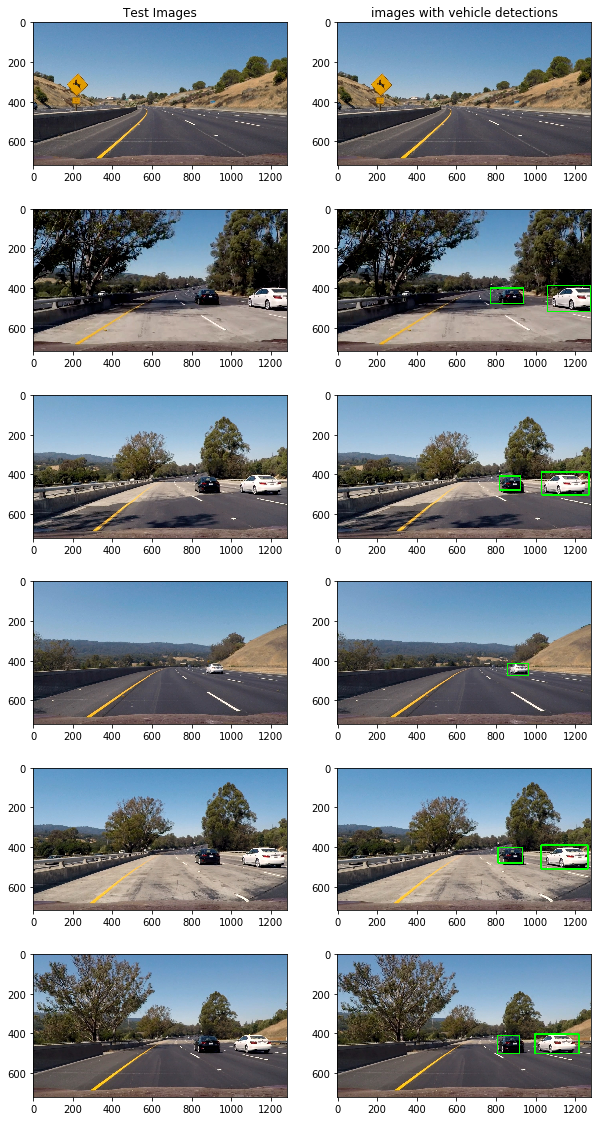

In [64]:
#testing on all test images from test_images

test_images = glob.glob('test_images/*.jpg')
num = len(test_images)
print(num)

plt.rcParams['figure.figsize'] = (10, 20)

for i in range(num):
    image = mpimg.imread(test_images[i])
    final = final_pipeline(image)
    
    
    plt.subplot(num,2,i*2+1)
    plt.imshow(image)
    #plt.axis('off')
    if i == 0:
        plt.title("Test Images")
    plt.subplot(num,2,i*2+2)
    plt.imshow(final)
    #plt.axis('off')
    if i == 0:
        plt.title("images with vehicle detections")

In [66]:
# Apply it on a video
from moviepy.editor import VideoFileClip

output = 'final_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(final_pipeline)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video final_output.mp4
[MoviePy] Writing video final_output.mp4


100%|█████████▉| 1260/1261 [27:53<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_output.mp4 

CPU times: user 1h 42min 4s, sys: 41 s, total: 1h 42min 45s
Wall time: 27min 54s
